# Expanding the measurement of culture with a sample of two billion humans

## Replication Data and Code

This notebook provides all the steps to replicate the results of our paper [Expanding the measurement of culture with a sample of two billion humans](https://doi.org/10.1098/rsif.2022.0085) published in the *Journal of the Royal Society Interface 19:20220085* (2022).

# Replication Divisiveness figures

# Setup and Pre-requisites

Let's start by importing the required packages

In [2]:
#%pylab --no-import-all
%matplotlib inline

import sys, os, time
import numpy as np
import pandas as pd
pd.set_option('display.width', 160)
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.iolib.summary2 import summary_col
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances, manhattan_distances, pairwise_distances
from scipy.stats import zscore
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy import spatial, stats
from scipy.stats import zscore
import MantelTest.MantelTest as MantelTest
from scipy.stats import pearsonr
import re
import seaborn as sns

Let's setup our paths

In [3]:
pathfb = './data/'
pathfbor = './data/OriginalData/'
pathout = pathfb + 'CohesionMain/'
pathcohesion = pathfb + 'CohesionMain/'
pathcenters = pathfb + 'CulturalCenters/'
if os.path.exists(pathout) == False:
    os.mkdir(pathout)
pathshare = pathout
if os.path.exists(pathcohesion) == False:
    os.mkdir(pathcohesion)

## Import data

In [4]:
cohesion_out1 = pd.read_csv(pathout + 'cohesion_all_pairs.csv', encoding='utf-8')
cohesion_gender_out1 = pd.read_csv(pathout + 'cohesion_gender_all_pairs.csv', encoding='utf-8')

cohesion_out1.set_index('country_code_1', inplace=True)
cohesion_gender_out1.set_index('country_code_1', inplace=True)

In [5]:
# Import WDI data for categorizing
wdi = pd.read_csv(pathcenters + 'WDI.csv', encoding='utf-8', keep_default_na=False, na_values='')
wdi.set_index('ISO_CODE', inplace=True)
wdi = wdi.reindex(cohesion_out1.reset_index().country_code_1.apply(lambda x: x[:2]).unique().tolist())[['region', 'incomeLevel']].copy()
wdi.columns = ['continent', 'income']
wdi.index.name = 'country_code_1'
markers_cont = {'East Asia & Pacific': 'x',
                'Europe & Central Asia': 'o',
                'Latin America & Caribbean ': '*',
                'North America': 's',
                'South Asia': '+',
                'Sub-Saharan Africa ': 'D'}
wdi['marker_cont'] = wdi.continent.map(markers_cont)
markers_inc = {'High income': 'o', 'Lower middle income': 's', 'Upper middle income': 'x'}
wdi['marker_inc'] = wdi.income.map(markers_inc)
colors_inc = {'High income': 'blue',
              'Lower middle income': 'darkorchid',
              'Upper middle income': 'crimson'}
wdi['colors_inc'] = wdi.income.map(colors_inc)

# Functions for plotting

In [7]:
SMALL_SIZE = 24
MEDIUM_SIZE = 28
BIGGER_SIZE = 32

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

def JointScatterPlot(df, df2, myvar, fileext='JointScatter_all_pairs', filenum='', ascending=True, title='FB Cultural Divisiveness', pathout=pathout):
    dffig = df[[myvar.replace('_gender', '')]].merge(df2[[myvar]], left_index=True, right_index=True).copy()
    agglo = dffig.index.name
    x = 'Region'
    y = 'Gender'
    dffig.columns = [x, y]
    dffig = dffig.merge(wdi, left_index=True, right_index=True)
    dffig.index.name = 'country_code_1'
    dffig = dffig.reset_index().copy()
    movex = dffig[x].mean() * 0.01
    movey = dffig[y].mean() * 0.01
    fig, ax = plt.subplots(figsize=(30,20))
    for line in range(0,dffig.shape[0]):
        ax.text(dffig.Region[line]++movex, dffig.Gender[line]+movey, dffig.country_code_1[line], horizontalalignment='left', fontsize=28, color='black', weight='semibold')
        ax.plot(dffig.Region[line], dffig.Gender[line], marker=dffig.marker_cont[line], c=dffig.colors_inc[line], markersize=28)
    for cont in np.sort(dffig.continent.unique()):
        ax.scatter([], [], c='k', alpha=1, marker=markers_cont[cont], label=cont)
    #leg = ax.legend(scatterpoints=1, frameon=False, labelspacing=1, title='Continent', prop={'size': 28}, markerscale=4, loc='upper right')
    #leg.set_title("Continent", prop = {'size':32})
    points2 = []
    for inc in ['High income', 'Upper middle income', 'Lower middle income']:
        points2 += [ax.scatter([], [], c=colors_inc[inc], alpha=1, marker='s', label=inc)]
    leg2 = ax.legend(points2, ['High income', 'Upper middle income', 'Lower middle income'], scatterpoints=1, frameon=False, labelspacing=1, title='Income', prop={'size': 28}, markerscale=4, loc='lower left')
    leg2.set_title("", prop = {'size':32})
    leg2.set_title("Income", prop = {'size':32})
    #ax.add_artist(leg)
    ax.tick_params(axis = 'both', which = 'major', labelsize=34)
    ax.tick_params(axis = 'both', which = 'minor', labelsize=18)
    ax.set_title('')
    ax.set_xlabel('Region Divisiveness', fontsize=38)
    ax.set_ylabel('Gender Divisiveness', fontsize=38)
    #plt.savefig(pathout + myvar.replace('_gender', '') + fileext +'.pdf', dpi=300, bbox_inches='tight')
    plt.savefig(pathout + 'Figure-7-' + filenum +'.pdf', dpi=300, bbox_inches='tight')
    #plt.savefig(pathout + myvar.replace('_gender', '') + fileext +'.png', dpi=300, bbox_inches='tight')
    plt.show()
    pass


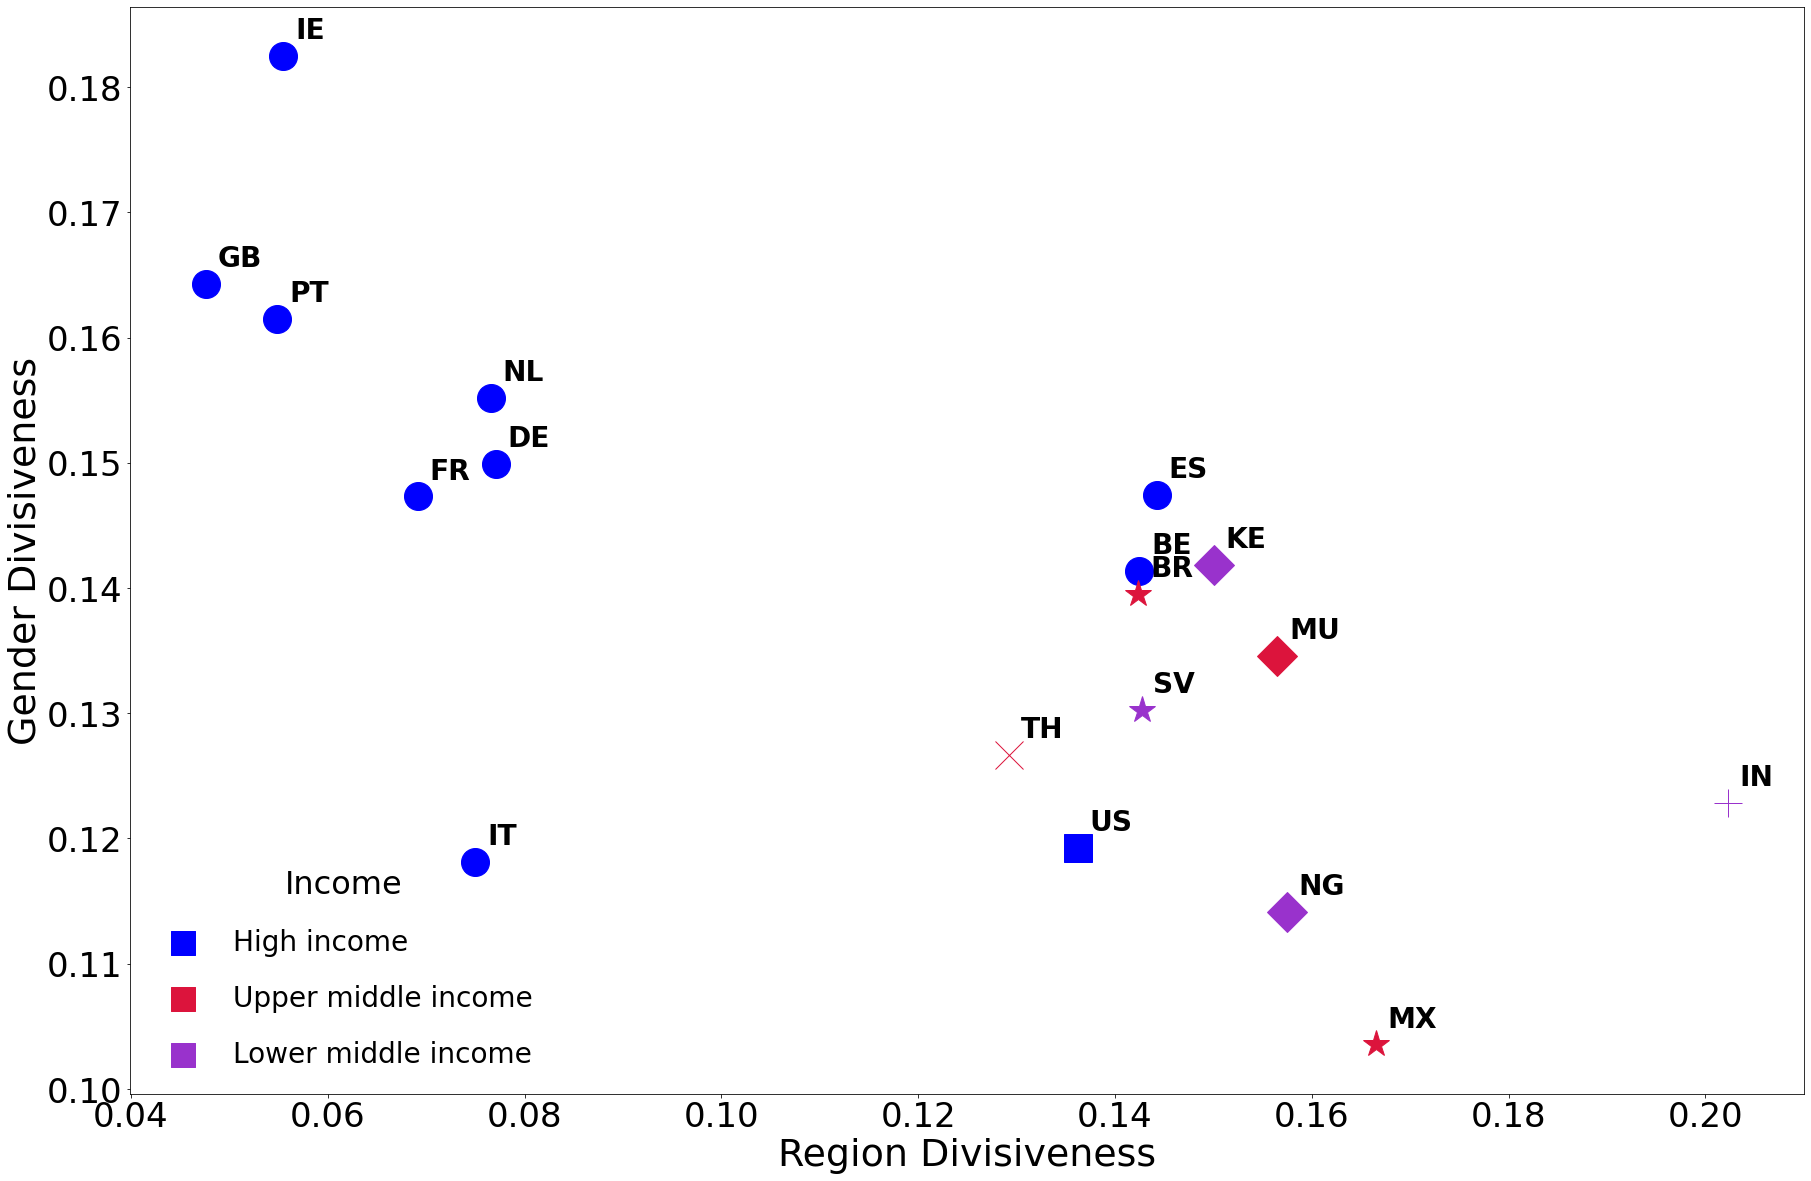

In [8]:
JointScatterPlot(cohesion_out1, cohesion_gender_out1, 'cohesion_gender_norm', pathout=pathout, filenum='B')

In [9]:
mycorr = cohesion_out1[['cohesion_norm']].merge(cohesion_gender_out1[['cohesion_gender_norm']], left_index=True, right_index=True)
mycorr.corr()

,cohesion_norm,cohesion_gender_norm
cohesion_norm,1.00000,-0.70213
cohesion_gender_norm,-0.70213,1.00000


In [10]:
pearsonr(mycorr.cohesion_norm, mycorr.cohesion_gender_norm)

(-0.7021302037814038, 0.0011603635998826511)

In [11]:
cohesion_out1 = pd.read_csv(pathout + 'Age_Gender/cohesion_age_all_pairs.csv', encoding='utf-8')
cohesion_gender_out1 = pd.read_csv(pathout + 'Age_Gender/cohesion_gender_all_pairs.csv', encoding='utf-8')
cohesion_out1.set_index('country_code_1', inplace=True)
cohesion_gender_out1.set_index('country_code_1', inplace=True)
cohesion_out1 = cohesion_out1.reindex(cohesion_out1.index.difference(['BR', 'IN', 'KE', 'KM', 'DJ']))
cohesion_gender_out1 = cohesion_gender_out1.reindex(cohesion_gender_out1.index.difference(['BR', 'IN', 'KE', 'KM', 'DJ']))

In [12]:
# Import WDI data for categorizing
wdi = pd.read_csv(pathcenters + 'WDI.csv', encoding='utf-8', keep_default_na=False, na_values='')
wdi.set_index('ISO_CODE', inplace=True)
wdi = wdi.reindex(cohesion_out1.reset_index()['country_code_1'].apply(lambda x: x[:2]).unique().tolist())[['region', 'incomeLevel']].copy()
wdi.columns = ['continent', 'income']
wdi.index.name = 'country_code_1'
markers_cont = {'East Asia & Pacific': 'x',
                'Europe & Central Asia': 'o',
                'Latin America & Caribbean ': '*',
                'Middle East & North Africa':'v',
                'North America': 's',
                'South Asia': '+',
                'Sub-Saharan Africa ': 'D'}
wdi['marker_cont'] = wdi.continent.map(markers_cont)
markers_inc = {'High income': 'o', 'Lower middle income': 's',
               'Upper middle income': 'x', 'Low income':'^'}
wdi['marker_inc'] = wdi.income.map(markers_inc)
colors_inc = {'High income': 'blue',
              'Lower middle income': 'darkorchid',
              'Upper middle income': 'crimson',
              'Low income': 'green'}
wdi['colors_inc'] = wdi.income.map(colors_inc)

In [13]:
def JointScatterPlot(df, df2, myvar, fileext='JointScatter_all_pairs', filenum='', ascending=True, title='FB Cultural Divisiveness', pathout=pathout):
    dffig = df[[myvar.replace('_gender', '')]].merge(df2[[myvar]], left_index=True, right_index=True).copy()
    agglo = dffig.index.name
    x = 'Age'
    y = 'Gender'
    dffig.columns = [x, y]
    dffig = dffig.merge(wdi, left_index=True, right_index=True)
    dffig.index.name = 'country_code_1'
    dffig = dffig.reset_index().copy()
    movex = dffig[x].mean() * 0.025
    movey = dffig[y].mean() * 0.025
    fig, ax = plt.subplots(figsize=(30,20))
    for line in range(0,dffig.shape[0]):
        ax.text(dffig.Age[line]+movex, dffig.Gender[line]+movey, dffig.country_code_1[line], horizontalalignment='left', fontsize=28, color='black', weight='semibold')
        ax.plot(dffig.Age[line], dffig.Gender[line], marker=dffig.marker_cont[line], c=dffig.colors_inc[line], markersize=28)
    for cont in np.sort(dffig.continent.unique()):
        ax.scatter([], [], c='k', alpha=1, marker=markers_cont[cont], label=cont)
    leg = ax.legend(scatterpoints=1, frameon=False, labelspacing=1, title='Continent', prop={'size': 28}, markerscale=4, loc='lower right')
    leg.set_title("Continent", prop = {'size':32})
    points2 = []
    for inc in ['High income', 'Upper middle income', 'Lower middle income', 'Low income']:
        points2 += [ax.scatter([], [], c=colors_inc[inc], alpha=1, marker='s', label=inc)]
    #leg2 = ax.legend(points2, ['High income', 'Upper middle income', 'Lower middle income', 'Low income'], scatterpoints=1, frameon=False, labelspacing=1, title='Income', prop={'size': 28}, markerscale=4, loc='upper center')
    #leg2.set_title("", prop = {'size':32})
    #leg2.set_title("Income", prop = {'size':32})
    ax.add_artist(leg)
    ax.tick_params(axis = 'both', which = 'major', labelsize=34)
    ax.tick_params(axis = 'both', which = 'minor', labelsize=18)
    ax.set_title('')
    ax.set_xlabel('Age Divisiveness', fontsize=38)
    ax.set_ylabel('Gender Divisiveness', fontsize=38)
    #plt.savefig(pathout + myvar.replace('_gender', '') + fileext +'.pdf', dpi=300, bbox_inches='tight')
    plt.savefig(pathout + 'Figure-7-' + filenum +'.pdf', dpi=300, bbox_inches='tight')
    #plt.savefig(pathout + myvar.replace('_gender', '') + fileext +'.png', dpi=300, bbox_inches='tight')
    plt.show()
    pass


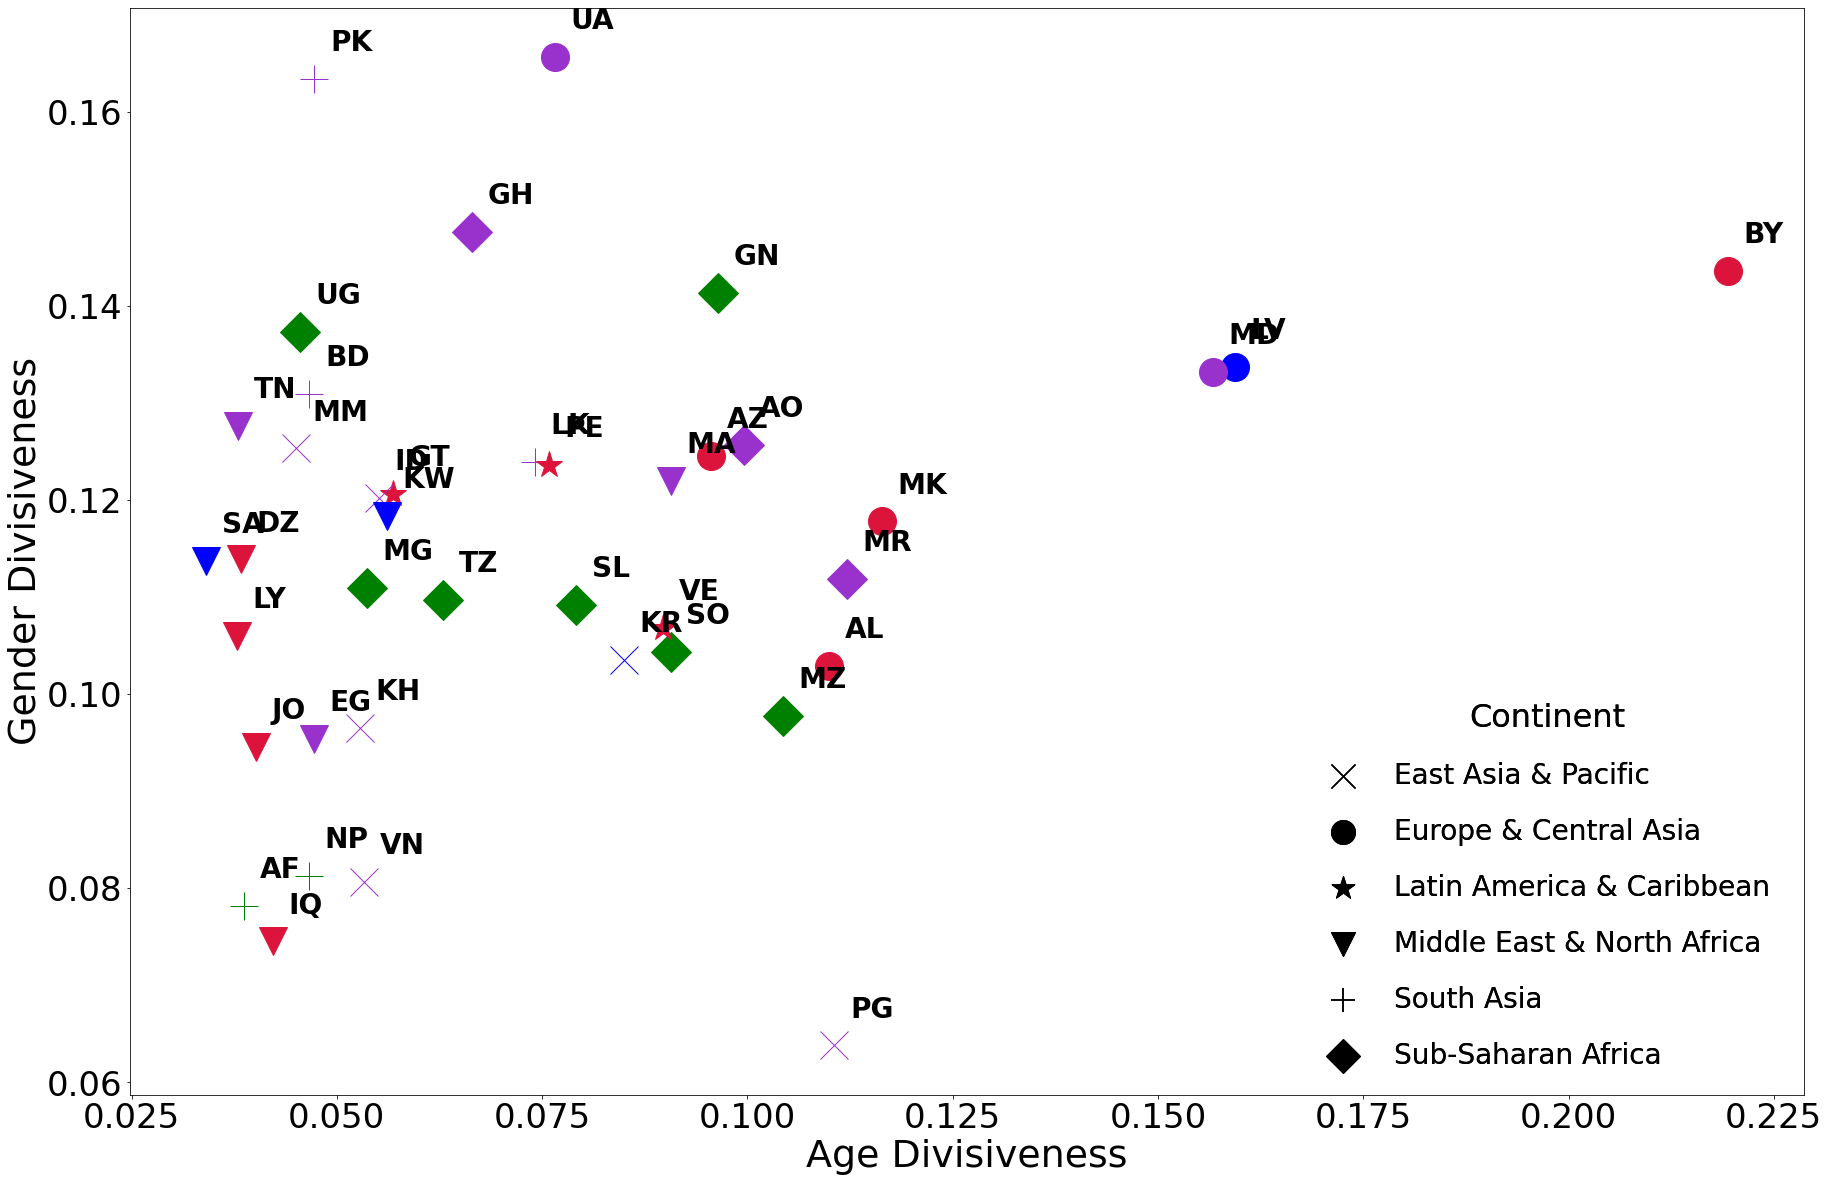

In [14]:
JointScatterPlot(cohesion_out1, cohesion_gender_out1, 'cohesion_gender_norm', pathout=pathout+'/Age_Gender/', filenum='A')

In [15]:
mycorr = cohesion_out1[['cohesion_norm']].merge(cohesion_gender_out1[['cohesion_gender_norm']], left_index=True, right_index=True)
mycorr.corr()

,cohesion_norm,cohesion_gender_norm
cohesion_norm,1.00000,0.23413
cohesion_gender_norm,0.23413,1.00000


In [16]:
pearsonr(mycorr.cohesion_norm, mycorr.cohesion_gender_norm)

(0.23413026829852301, 0.1459147997107791)